![](pics/header.jpg)

# Mahony Filter

Kevin J. Walchko, Phd

3 Jan 2021

---

## References

- [Madgwick, *An efficient orientation filter for inertial and inertial/magnetic sensor arrays*](madgwick.pdf)

## Quaternion Basics

Here we will use Hamiltonian (right-handed) quaternions throughout this work. The notation on the quaternion frames is $^{From}_{To}q$.

$$
^A_Cq = {}^B_Cq \otimes {}^A_Bq \\
^A_Bq = \begin{bmatrix} q_1 & q_2 & q_3 & q_4 \end{bmatrix} \\
^A_Bq^* = {}^B_Aq = \begin{bmatrix} q_1 & -q_2 & -q_3 & -q_4 \end{bmatrix} \\
^Bv = {}^A_Bq \otimes {}^Av \otimes {}^A_Bq^* 
$$

# Filter Equations

Madgwick did a great job designing this filter, but I find his paper hard to follow, especially with several typos in the mathematics. So I tried to boil it down to the useful equations.

![](pics/imu.png)

## Definitions

| Symbol | Definition |
|---|:---|
| $S$ | Sensor Frame |
| $E$ | Earth Frame |
| $||x||$ | Norm of $x$ |
| $f_{g}$ | Objective function|
| $J_{g}$ | Jacobian of the objective funtion based on the gravity reference |
| $\nabla f$ | Gradient of the cost function which is composed of Jacobian and the objective function: $J^T_g f_g$ |
| $\omega_t$ | Raw gyro values |
| $\omega_b$ | Estimated gyro bias |
| $\omega_c$ | Converted gyro values free of biases |
| $a_t$ | accelerometer values |
| $\beta$ | Gain for filter or learning rate based on gradient feedback |
| $^S_Eq_t$ | Orientation at current time step |
| $^Eg$ | Gravitational reference, $\begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$ |


## Initialize

$$
^S_Eq_t = \begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix} \\
^{S}\omega_{b,t} = \begin{bmatrix} 0 & 0 & 0 \end{bmatrix}^T
$$

## Loop

1. Get accelerometer ($^Sa_t$) and gyroscope ($^S\omega_t$) from the IMU
1. Normalize $^Sa_t$
1. Make sure the gyro is converted, if necessary, to rads/sec
1. Calculate time step $\Delta t$ from last sample time
1. Calculate the gradient $\nabla f$ and normalize to get $\frac{\nabla f}{|| \nabla f||}$, the formulation of $\Delta f$ is discussed below in the gradient section
1. Calculate the gyro bias:
    1. Estimate the error [47]: $^{S}\omega_{\epsilon,t} = 2^S_E\hat q^{*}_{est,t-1} \otimes \frac{\nabla f}{|| \nabla f||}$
    1. Integrate (discrete time) to get the current bias estimate [48]: $^{S}\omega_{b,t} = \zeta \sum ^{S}\omega_{\epsilon,t} \Delta t$
        1. $\zeta$ is the drift rate (rad/s/s) $\sqrt{\frac{3}{4}} \dot \omega_{\zeta}$
    1. Correct the raw gyro values [49]: $^{S}\omega_{c,t} = ^{S}\omega_{t} - ^{S}\omega_{b,t}$
1. Update orientation based on corrected gyros [12]: $^{S}_{E}\dot q_{\omega,t} = \frac{1}{2} ^{S}_{E}\hat q_{est,t-1} \otimes ^{S}\omega_{c,t}$
1. Correct the orientation rate using the estimated error [43]: $^{S}_{E}\dot q_{est,t} = ^{S}_{E}\dot q_{\omega,t} - \beta \frac{\nabla f}{|| \nabla f||}$
    1. Now $\beta$ is based on the error (rad/s) of  the gyro, you can use: $\sqrt{\frac{3}{4}} \omega_{\beta}$
1. Integrate (discrete time) the orientation rate to get the updated orientation [42]: $^{S}_{E}\hat q_{est,t} = ^{S}_{E}\hat q_{est,t-1} + ^{S}_{E}\dot q_{est,t} \Delta t$

## Gradient

For the imu filter, the gradient uses [21] and [22]. By substituting in values for gravity ($^Eg = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$) and the magnetic field reference, the equation simplify down to [25],[26]:

$$
\nabla f = J^T_g f_g\\
f_g(^{S}_{E}\hat q_{est,t-1}, a_t) = \begin{bmatrix}
    2(q_2q_4-q_1q_3)-a_x \\
    2(q_1q_2+q_3q_4)-a_y \\
    2(0.5-q_2^2-q_3^2)-a_z
\end{bmatrix} (eqn.25)\\
J_g(^{S}_{E}\hat q_{est,t-1}) = \begin{bmatrix}
    -2q_3 &  2q_4 & -2q_1 & 2q_2 \\
     2q_2 &  2q_1 &  2q_4 & 2q_3 \\
        0 & -4q_2 & -4q_3 &    0
\end{bmatrix} (eqn.26)\\
$$

# Get Data

In [4]:
import numpy as np # matrix manipulations
# from numpy.linalg import norm

from ins_nav.filters import Mahony
from ins_nav.storage import from_pickle

from squaternion import Quaternion

# import pandas as pd

from matplotlib import pyplot as plt 

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

In [3]:
!ls -lh *.pkl

-rw-r--r--  1 kevin  staff   586K Jul 10 08:32 data-2022-07-10.pkl
-rw-r--r--  1 kevin  staff    49K Jul 10 10:01 data-mag-2022-07-10.pkl


In [16]:
# def bag_info(bag):
#     print('Bag keys:')
#     print('-'*50)
#     for k in bag.keys():
#         print(f'  {k:>10}: {len(bag[k]):<7}')

        
# def get(data):
#     ret = []
#     ts = []
#     for d,t in data:
#         ret.append(d)
#         ts.append(t)
#     return np.array(ret), ts


# if 0:
#     bag = BagIt(Pickle)
#     fname = "imu-rpi.2019-05-04-20:47:18.445193.pickle.bag"
#     data = bag.read(fname)
# else:
#     bag = the_collector.BagIt(Json)
#     bag.packer.compress(True)
#     fname = "imu-1-2.json-gz.bag"
#     data = bag.read(fname)

# print(f">> Bagit keys: {data.keys()}")
# bag_info(data)

filename = "data-mag-2022-07-10.pkl"
datainfo = from_pickle(filename)
data = np.array(datainfo["data"])

accel = data[:,0:3]
gyro = data[:,3:6]
mag = data[:,6:9]
stamp = data[:,-1]

# accel, stamp = get(data["accel"])
# gyro, _ = get(data["gyro"])
# mag, stamp = get(data["mag"])

>> Loaded data from data-mag-2022-07-10.pkl


# Run AHRS

Now the AHRS uses all of the sensors in the IMU. The code is shown below:

In [17]:
# this seems wrong, give different answer than Wikipedia
# also, his quaternions are different [c(t/2), -r*s(t/2), ...], why negative?
from math import atan2, asin, pi
def euler(q):
    q1,q2,q3,q4 = q
    r2d = 180/pi
    y = atan2(2*q2*q3-2*q1*q4,2*q1**2+2*q2**2-1) * r2d
    p = -asin(2*q2*q4+2*q1*q3) * r2d
    r = atan2(2*q3*q4-2*q1*q2,2*q1**2+2*q4**2-1) * r2d

    # adafruit
#     q0,q1,q2,q3 = q
#     r = atan2(q0 * q1 + q2 * q3, 0.5 - q1 * q1 - q2 * q2) * r2d
#     p = asin(-2.0 * (q1 * q3 - q0 * q2)) * r2d
#     y = atan2(q1 * q2 + q0 * q3, 0.5 - q2 * q2 - q3 * q3) * r2d
    return (r,p,y,)

# Test

Ground truth:

- CW ~390, greater than 1 full rotation
- CCW ~410, back pass the starting point some
- Back to start + ~30, ended CW more than the starting point

In [18]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"tt":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time
# q = Quaternion()
B = sqrt(3/4)*5*pi/180  # gyro measurement error rad/s
filt = Mahony(B)
filt.wcomp = False
wes = []

for a, g, ts in zip(accel, gyro, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g*np.pi/180,dt)  # get orientation
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
#     r,p,y = euler(q) # madgwick's appears wrong!
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    e["tt"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

# euler2 = pd.DataFrame(e)

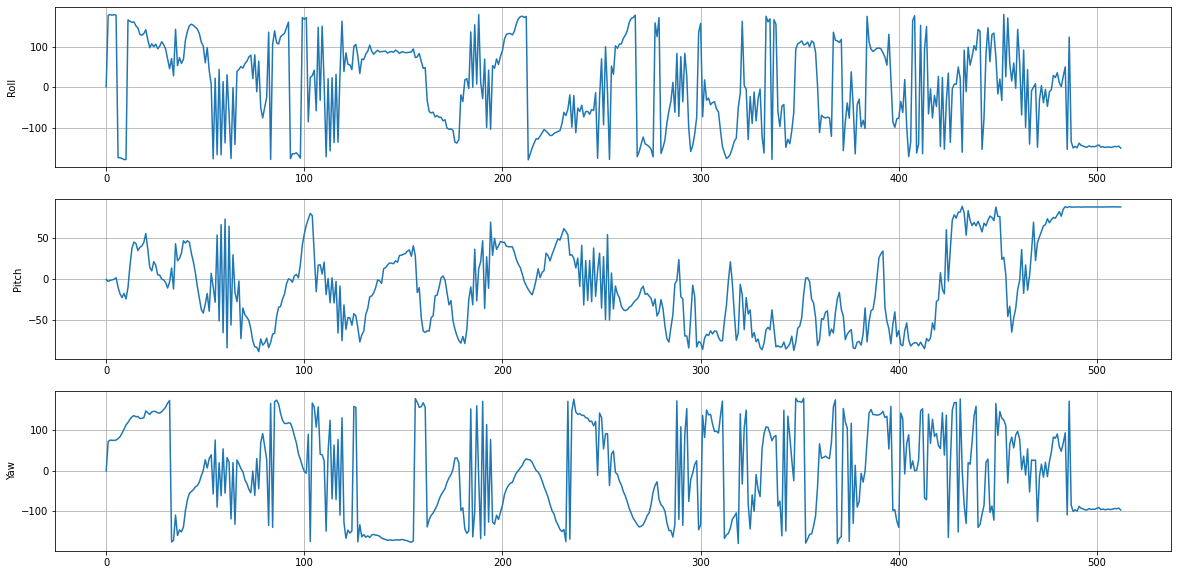

In [19]:
# euler2.plot(
#     x="tt", 
#     subplots=True, grid=True, 
#     title="Euler Angles [deg]",
#     ylabel="Angle [deg]",
#     xlabel="Time [sec]"
# );

plt.figure(figsize=(20,10))

plt.subplot(311)
plt.plot(e["roll"]); plt.ylabel("Roll"); plt.grid(True)
plt.subplot(312)
plt.plot(e["pitch"]); plt.ylabel("Pitch"); plt.grid(True)
plt.subplot(313)
plt.plot(e["yaw"]); plt.ylabel("Yaw"); plt.grid(True)


[0 0 0]


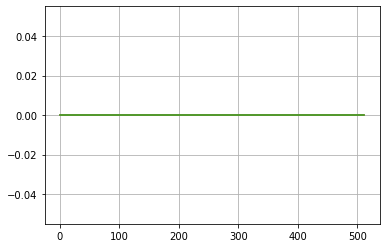

In [20]:
print(filt.wb)
plt.plot(wes)
plt.grid(True);

# Appendix: Code

In [21]:
from jtb import getCode

getCode(imp=Mahony)